# Predicting the price of BMW cars

**We use GradientBoostRegressor and RandomForestRegressor to estimate the price of a BMW car
The steps included in the kernel are**
1. Preprocessing the data. This is mostly related to categorising and transforming the data
2. Splitting the data into testing and training data
3. Prediction

**Point of Interest**
We have one problem in our data. Splitting the data into test/train sets will also result into the fact that we may miss some car models in either the test or train sets. To address this we replicate the car models that have a minimum car count. This results in better trained/tested models as shown along the feature importance plots.
And final run of the code uses the 8 features as mentioned by the description of the dataset. Surprisingly these features are of lesser value and are not good for descrimination.

<a href="#pre"> Preprocessing </a>

<a href="#graphs"> Graphs </a>

<a href="#prediction">Prediction</a>

<a href="#replicate">Replication of low count car models</a>

<a href="#replicate_prediction">Prediction</a>

<a href="#desc_features_run">8 Features based prediction</a>


In [153]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

def save_img(name, ext="pdf"):
    plt.savefig("pred_features/" + name + "." + ext, bbox_inches='tight')

# Any results you write to the current directory are saved as output.

['pred', 'pred_features', 'analiza', 'bmw_pricing_challenge.csv', '.ipynb_checkpoints', 'starter-bmw-pricing-challenge-d8c6c2c2-9.ipynb', '.idea', 'drzewko.pdf', 'kernelb575fced68.ipynb', 'bmw-regressors-price-prediction.ipynb', 'bmw_regression.ipynb', 'bmw-pricing-challenge-77-true-prediction.ipynb']


<a id='pre'></a>
# Data Pre-processing

In [154]:
#Lets drop unwanted columns
df = pd.read_csv('./bmw_pricing_challenge.csv', delimiter=',')
#Convert string/text to categorical values
car_models = df.model_key.copy()
c = car_models.value_counts()
model_labels = df['model_key'].astype('category').cat.categories.tolist()
model_labels_dict = {k: v for k,v in zip(model_labels,list(range(1,len(model_labels)+1)))}
fuel_labels = df['fuel'].astype('category').cat.categories.tolist()
fuel_labels_dict = {k: v for k,v in zip(fuel_labels,list(range(1,len(fuel_labels)+1)))}
paint_labels = df['paint_color'].astype('category').cat.categories.tolist()
paint_labels_dict =  {k: v for k,v in zip(paint_labels,list(range(1,len(paint_labels)+1)))}
type_labels = df['car_type'].astype('category').cat.categories.tolist()
type_labels_dict =  {k: v for k,v in zip(type_labels,list(range(1,len(type_labels)+1)))}
df['sold_at'] = pd.to_datetime(df['sold_at'])
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['age'] = (df['sold_at'] - df['registration_date']).apply(lambda x: x.days // 365)
df.drop(["maker_key","sold_at", 'registration_date'], axis=1, inplace=True)
df.replace(model_labels_dict, inplace=True)
df.replace(fuel_labels_dict, inplace=True)
df.replace(paint_labels_dict, inplace=True)
df.replace(type_labels_dict, inplace=True)

df['model_key'] = df['model_key'].astype('category')

scaler = MinMaxScaler(feature_range=(0, 1))

print(df.dtypes)

model_key       category
mileage            int64
engine_power       int64
fuel               int64
paint_color        int64
car_type           int64
feature_1           bool
feature_2           bool
feature_3           bool
feature_4           bool
feature_5           bool
feature_6           bool
feature_7           bool
feature_8           bool
price              int64
age                int64
dtype: object


<a id='regression_func'></a>
# Regression 

In [155]:
seed = 5811
from matplotlib.ticker import PercentFormatter
def feature_importance_plots(regressor,columns, name):
        feature_importances = pd.DataFrame(regressor.feature_importances_,index = columns, columns=['importance']).sort_values('importance', ascending=False)
        print(feature_importances)
        category_histo("Ważność atrybutów",
                       "Atrybut", 
                       "Wartość procentowa udziału",
                       feature_importances, name
                      )

def category_histo(title, xlabel, ylabel, data, name):
    plt.figure(figsize=(15,10))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax = sns.barplot(orient="v", x=data.index, y=data['importance'])
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
    
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height() * 100, '.2f') + "%", (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    save_img(name)
    plt.show()

        
def test_reg(reg, X_train, y_train, X_test, y_test, name, postfix, df, price, show_weights=True, run_cv=True):
    if show_weights:
        print('Parameters currently in use:\n')
        pprint(reg.get_params())
    # Fit the training data
    reg.fit(X_train, y_train)
    # get the predicted values from the test set
    
    predicted_price = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    print(name + ' R squared: %.4f' % score)
    lin_mse = mean_squared_error(predicted_price, y_test)
    lin_rmse = np.sqrt(lin_mse)
    print('RMSE: %.4f' % lin_rmse)
    if run_cv:
        cv = cross_val_score(reg, df, price, cv=10)
    else:
        cv = []
    return score, lin_rmse, cv

def check_regressor(X_train, y_train, X_test, y_test, postfix, df, price, name, values, set_param, model, title, xlabel, show_weights=True, run_cv=True):
    scores = []
    ccros=[]
    stds = []
    for n in values:
        set_param(n)
        s, err, cv = test_reg(model, X_train, y_train, X_test, y_test, name + str(n), postfix, df, price, False, run_cv)
        scores.append(s)
        ccros.append(np.mean(cv))
        stds.append(np.std(cv))
    if show_weights and hasattr(model, 'feature_importances_'):
        max_index = np.argmax(scores)
        set_param(values[max_index])
        test_reg(model, X_train, y_train, X_test, y_test, name + str(n), postfix, df, price, True, False)
        feature_importance_plots(model,df.columns, name + '_' + postfix)
    ccros = np.array(ccros)
    stds = np.array(stds)
    plt.figure(figsize=(7, 5))
    plt.plot(values, scores, label="Score", color="green")
    plt.plot(values, ccros, label="Score 10-cv", color="blue")
    plt.fill_between(values, ccros - stds, ccros + stds, alpha=0.2, color="darkorange", label="Odchylenie")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    sns.lineplot(x=values, y=scores)
    save_img(name +"_x_"+ postfix)
    plt.show()
    
def check_rf(X_train, y_train, X_test, y_test, postfix, df, price):
    rfr = RandomForestRegressor(n_estimators=100,min_samples_split=3,random_state=seed)
    neighbors = [i for i in range(20,140,20)]
    check_regressor(X_train, y_train, X_test, y_test, postfix, df, price,
                    "RFR", neighbors, lambda v: rfr.set_params(n_estimators=v), rfr,
                    "Wpływ liczby estymatorów na trafność RFR", "liczba estymatorów", True)
    
def check_gbr(X_train, y_train, X_test, y_test, postfix, df, price):
    gbr = GradientBoostingRegressor(loss ='ls',n_estimators=100, max_depth=7,max_leaf_nodes = 9,random_state=seed)
    neighbors = [i for i in range(20,160,20)]
    check_regressor(X_train, y_train, X_test, y_test, postfix, df, price,
                    "GBR", neighbors, lambda v: gbr.set_params(n_estimators=v), gbr,
                    "Wpływ liczby estymatorów na trafność GBR", "liczba estymatorów", True)
        
        
def check_knn(X_train, y_train, X_test, y_test, postfix, df, price):
    knn = KNeighborsRegressor(n_neighbors=5)
    neighbors = list(range(3,11))
    check_regressor(X_train, y_train, X_test, y_test, postfix, df, price,
                    "KNN", neighbors, lambda v: knn.set_params(n_neighbors=v), knn,
                    "Wpływ liczby sąsiadów na KNN", "liczba sąsiadów", True)
    
def check_rnr(X_train, y_train, X_test, y_test, postfix, df, price):
    knn = RadiusNeighborsRegressor(radius=1)
    neighbors = [i*10  for i in range(1,10)]
    check_regressor(X_train, y_train, X_test, y_test, postfix, df, price,
                    "RNR", neighbors, lambda v: knn.set_params(radius=v), knn, 
                    "Wpływ promienia na RNR", "wielkość promienia", True, False)

def check_tree(X_train, y_train, X_test, y_test, postfix, df, price):
    knn = DecisionTreeRegressor(random_state=seed, min_samples_split=55, min_samples_leaf=5, max_depth=10)
    neighbors = [i for i in range(30,80,5)]
    check_regressor(X_train, y_train, X_test, y_test, postfix, df, price,
                    "Tree_samples", neighbors, lambda v: knn.set_params(min_samples_split=v), knn, 
                    "Wpływ wartości 'min_samples_split' na wynik drzewa decyzyjnego",
                    "Wartość minimalnego progu podziału węzła", True, True)
#     dot_data = StringIO()
#     export_graphviz(knn, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#     graph.write_pdf("drzewko.pdf")
#     Image(graph.create_png())
    
def do_prediction(df, stratify, postfix):
    price = df.price.copy()
    df.drop(['price'],inplace=True,axis = 1)
    
#     scaled = scaler.fit_transform(df)
    if stratify and 'model_key' in df:
         X_train, X_test, y_train, y_test = train_test_split(df,price, test_size=0.25, stratify=df['model_key'], random_state=seed) 
    else:
        X_train, X_test, y_train, y_test = train_test_split(df, price, test_size=0.25, random_state=seed)
#     check_knn(X_train, y_train, X_test, y_test, postfix, df, price)
#     check_rnr(X_train, y_train, X_test, y_test, postfix, df, price)
#     check_tree(X_train, y_train, X_test, y_test, postfix, df, price)
    check_gbr(X_train, y_train, X_test, y_test, postfix, df, price)
    check_rf(X_train, y_train, X_test, y_test, postfix, df, price)

In [156]:
def do_prediction_i8(df):
    print(df[df['model_key'] == 75])
    price = df.price.copy()
    df.drop(['price'],inplace=True,axis = 1)
    gbr = GradientBoostingRegressor(loss ='ls',n_estimators=100, max_depth=7,max_leaf_nodes = 9,random_state=seed)
    gbr.fit(df, price)
    # get the predicted values from the test set
    
#     predicted_price = gbr.predict(df)
#     score = gbr.score(df, price)
    i8 = pd.DataFrame([{'model_key':75,'mileage':12402,
                  'engine_power':170,'fuel': 3,
                  'paint_color':6,'car_type':2,
                  'age': 2,
                  'feature_1':True, 'feature_2':True,
                  'feature_3':False, 'feature_4':False,
                  'feature_5':False, 'feature_6':False,
                  'feature_7':False, 'feature_8':True
                 }])
    print(gbr.predict(i8))

In [157]:
df_copyx=replicate_low_count(df.copy())
do_prediction_i8(df_copyx)
# type_labels_dict['coupe']

DataFrame size before append: 4843
DataFrame after append: 4893
     model_key  mileage  engine_power  fuel  paint_color  car_type  feature_1  \
90          75    12402           170     3            6         2       True   
4879        75    12402           170     3            6         2       True   
4880        75    12402           170     3            6         2       True   

      feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
90         True      False      False      False      False      False   
4879       True      False      False      False      False      False   
4880       True      False      False      False      False      False   

      feature_8    price  age  
90         True  95200.0    2  
4879       True  95200.0    2  
4880       True  95200.0    2  
[22927.05600999]


<a id='prediction'></a>
# Prediction

Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 6969,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR20 R squared: 0.8027
RMSE: 3823.4815
              importance
engine_power    0.433038
age             0.203293
model_key       0.157451
mileage         0.138762
feature_8       0.043023
feature_5       0.008708
feature_2       0.005314
feature_4       0.004988
feature_1       0.001992
feature_3       0.001309
feature_6       0.001172
car_type        0.000949
fuel            0.000000
paint_color     0.000000
feature_7       0.000000


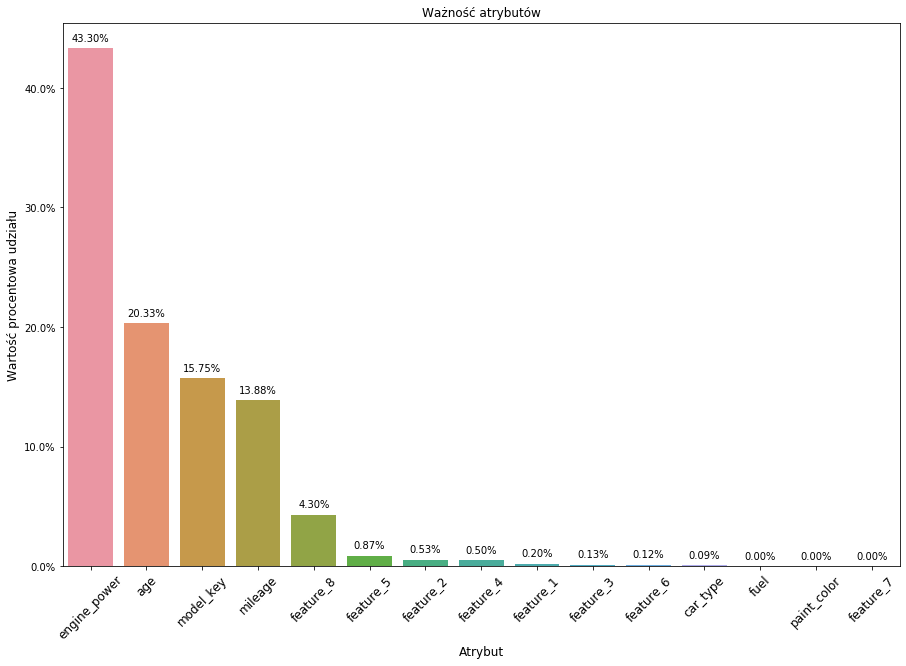

GBR40 R squared: 0.8691
RMSE: 3113.8652
GBR60 R squared: 0.8806
RMSE: 2974.2737
GBR80 R squared: 0.8865
RMSE: 2900.1297
GBR100 R squared: 0.8876
RMSE: 2886.4200
GBR120 R squared: 0.8891
RMSE: 2866.0488
GBR140 R squared: 0.8888
RMSE: 2871.0407


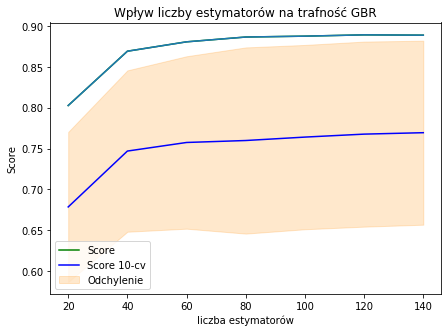

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6969,
 'verbose': 0,
 'warm_start': False}
RFR20 R squared: 0.8388
RMSE: 3456.0214
              importance
engine_power    0.392438
age             0.179028
mileage         0.162868
model_key       0.156192
feature_7       0.018240
feature_5       0.016259
car_type        0.015535
paint_color     0.011901
feature_3       0.010671
feature_8       0.010077
feature_2       0.009643
feature_6       0.006746
feature_4       0.005067
feature_1       0.003712
fuel            0.001621


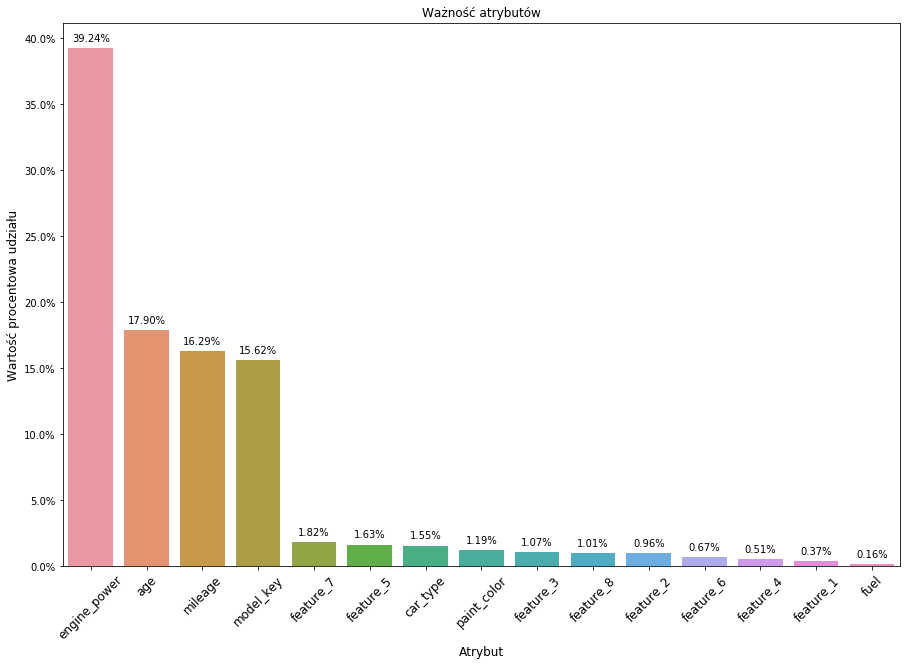

RFR40 R squared: 0.8511
RMSE: 3321.6862
RFR60 R squared: 0.8580
RMSE: 3244.0704
RFR80 R squared: 0.8544
RMSE: 3284.2414
RFR100 R squared: 0.8528
RMSE: 3302.6166
RFR120 R squared: 0.8580
RMSE: 3243.4934


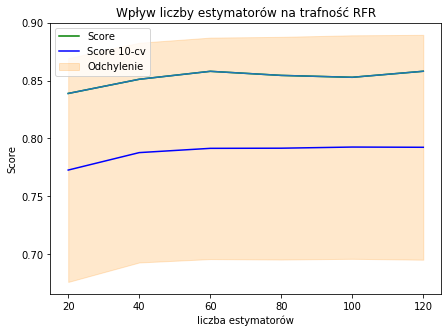

In [72]:
do_prediction(df.copy(),False, '1')

<a id='replicate'></a>
# Replicating car models that have a low count in our data

In [93]:
def replicate_low_count(df_copy):
    # What if between test/train splits we dont have the models of cars available?
    # For that we find the bear minimum count and replicate the data. 
#     repeated = pd.concat([df_copy]*10, ignore_index=True)

    min_counted = c <= 3
    # Lets populate the data with replicas for the car models
    
    print("DataFrame size before append:",len(df_copy))
    for item in min_counted.iteritems():
        if item[1]:
            v = model_labels_dict[item[0]]
            v2 = df_copy[df_copy['model_key'] == v].copy()
            if len(v2) > 1:# Keep one copy- this happens when min_counted > 1
                mean_price = v2["price"].mean()
                v2 = v2.iloc[[0]].copy()
                v2["price"] = mean_price
            for copy_count in range(0,2):
                df_copy = df_copy.append(v2,ignore_index=True)
    
    print("DataFrame after append:",len(df_copy))
    return  df_copy

<a id='replicate_prediction'></a>
# Replicate prediction

DataFrame size before append: 4843
DataFrame after append: 4893
GBR20 R squared: 0.8092
RMSE: 3943.8334
GBR40 R squared: 0.8804
RMSE: 3123.2088
GBR60 R squared: 0.8916
RMSE: 2972.7537
GBR80 R squared: 0.8979
RMSE: 2885.0085
GBR100 R squared: 0.9019
RMSE: 2828.5782
GBR120 R squared: 0.9044
RMSE: 2791.3149
GBR140 R squared: 0.9058
RMSE: 2771.4918
Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 140,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 5811,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR140 R squared: 0.9058
RMSE: 2771.4918
              importance
engine_power    0.338565
model_key       0.201596
age        

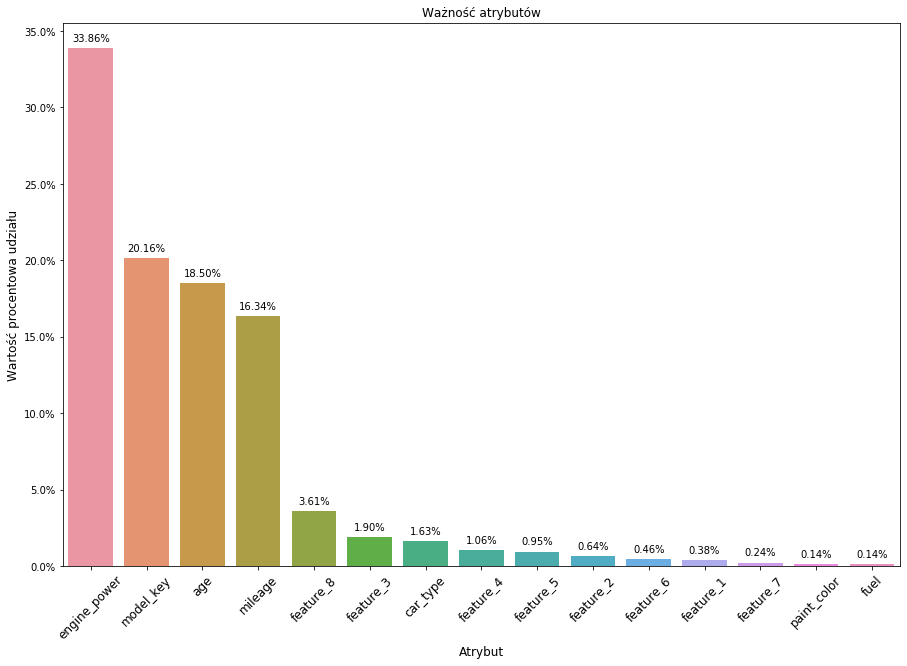

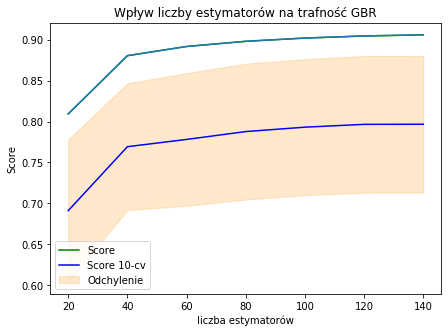

RFR20 R squared: 0.8953
RMSE: 2921.5536
RFR40 R squared: 0.8983
RMSE: 2879.8155
RFR60 R squared: 0.8972
RMSE: 2894.5183
RFR80 R squared: 0.8996
RMSE: 2860.8465
RFR100 R squared: 0.9010
RMSE: 2841.4567
RFR120 R squared: 0.9017
RMSE: 2830.4478
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5811,
 'verbose': 0,
 'warm_start': False}
RFR120 R squared: 0.9017
RMSE: 2830.4478
              importance
engine_power    0.365883
mileage         0.186194
model_key       0.175584
age             0.165658
feature_2       0.018418
car_type        0.016235
feature_5       0.013028
paint_color     0.012811
feature_8       0.011480
feature_1       0.007704
feature_3       0.007662
feature_4    

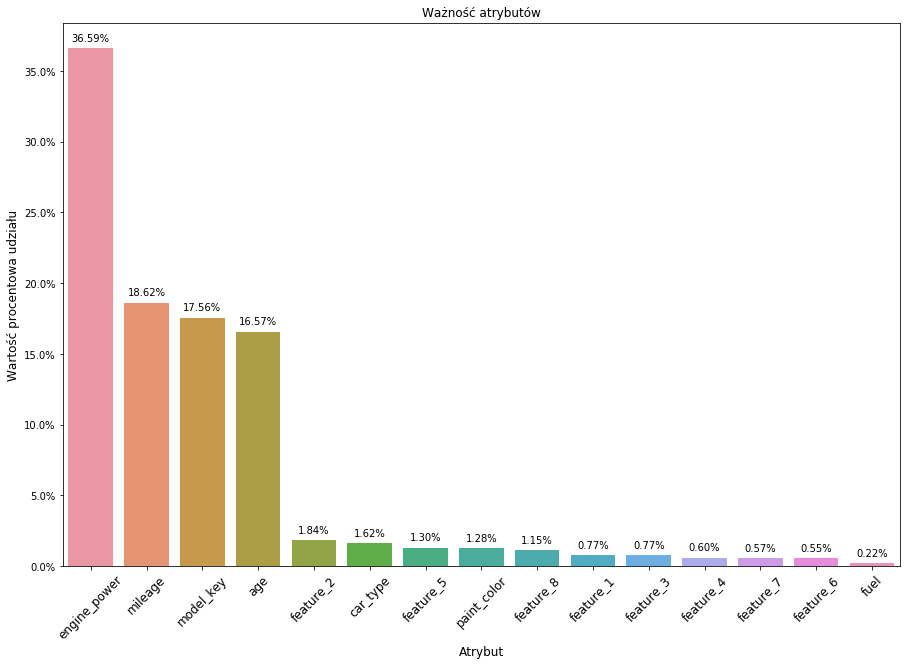

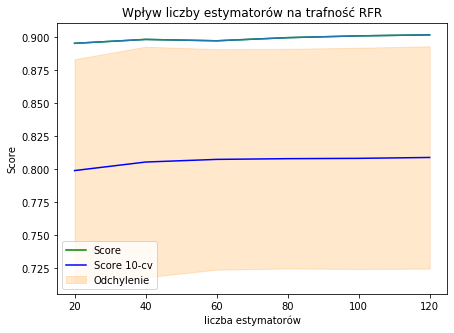

In [94]:
df_copy=replicate_low_count(df.copy())

do_prediction(df_copy,True, 'replicatedx3')

<a id="desc_features_run"></a>
# 8 Features based prediction

DataFrame size before append: 4843
DataFrame after append: 4893
DataFrame size before append: 4843
DataFrame after append: 4893
GBR20 R squared: 0.3604
RMSE: 6965.0750
GBR40 R squared: 0.3737
RMSE: 6892.1712
GBR60 R squared: 0.3782
RMSE: 6867.5437
GBR80 R squared: 0.3784
RMSE: 6866.2845
GBR100 R squared: 0.3786
RMSE: 6865.0850
GBR120 R squared: 0.3764
RMSE: 6877.7104
GBR140 R squared: 0.3751
RMSE: 6884.7446
Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 5811,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR140 R squared: 0.3786
RMSE: 6865.0850
           importance


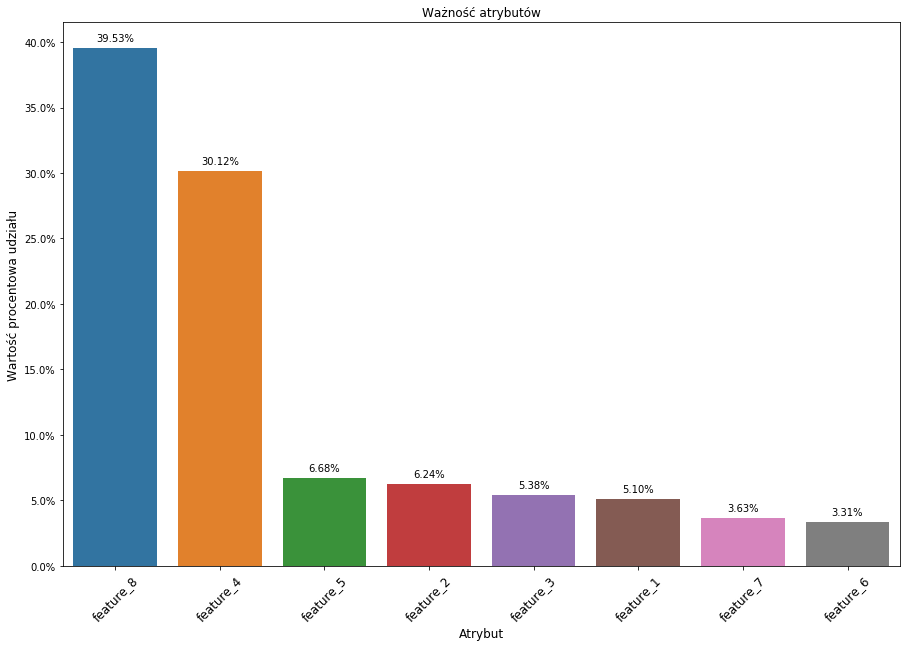

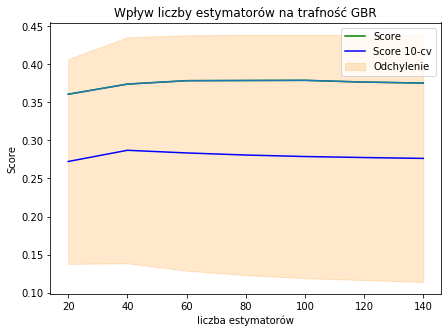

RFR20 R squared: 0.3764
RMSE: 6877.6585
RFR40 R squared: 0.3757
RMSE: 6881.4730
RFR60 R squared: 0.3725
RMSE: 6898.7515
RFR80 R squared: 0.3729
RMSE: 6896.9755
RFR100 R squared: 0.3730
RMSE: 6896.1638
RFR120 R squared: 0.3738
RMSE: 6891.9300
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5811,
 'verbose': 0,
 'warm_start': False}
RFR120 R squared: 0.3764
RMSE: 6877.6585
           importance
feature_8    0.380681
feature_4    0.281243
feature_5    0.071715
feature_2    0.071241
feature_1    0.061005
feature_3    0.050517
feature_7    0.044507
feature_6    0.039092


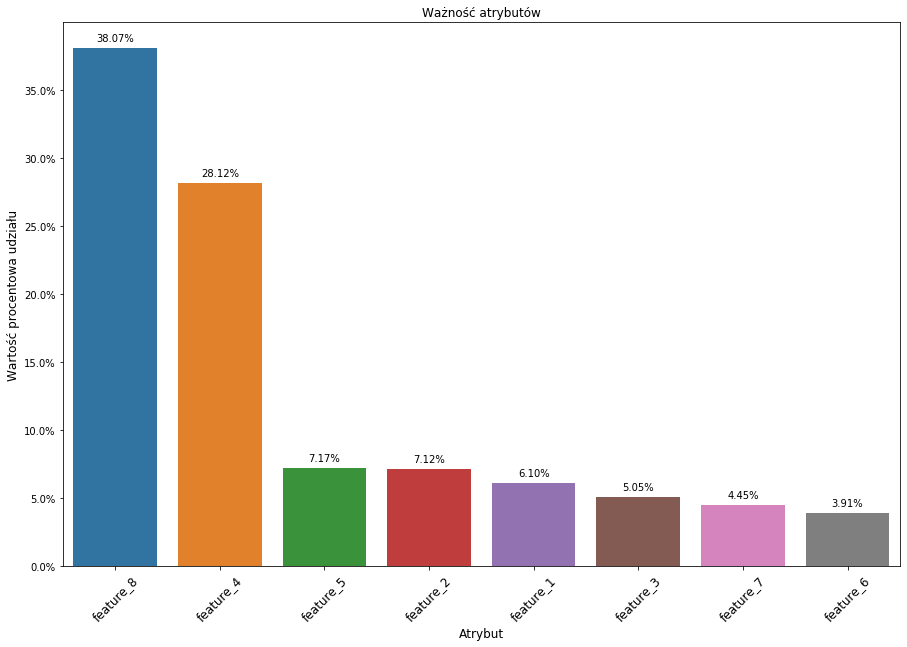

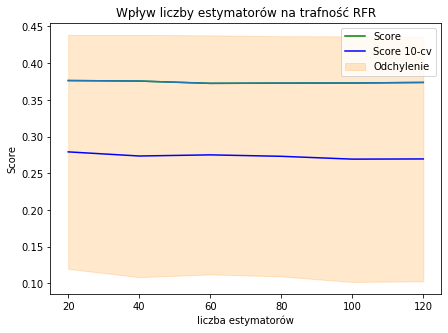

GBR20 R squared: 0.4369
RMSE: 6628.4281
GBR40 R squared: 0.4624
RMSE: 6476.7538
GBR60 R squared: 0.4621
RMSE: 6478.5668
GBR80 R squared: 0.4603
RMSE: 6489.2389
GBR100 R squared: 0.4580
RMSE: 6503.2193
GBR120 R squared: 0.4568
RMSE: 6510.3516
GBR140 R squared: 0.4552
RMSE: 6519.8927
Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 5811,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR140 R squared: 0.4624
RMSE: 6476.7538
           importance
feature_8    0.472783
feature_4    0.214950
feature_5    0.064714
feature_1    0.056698
feature_2    0.053986
feature_7    0.0539

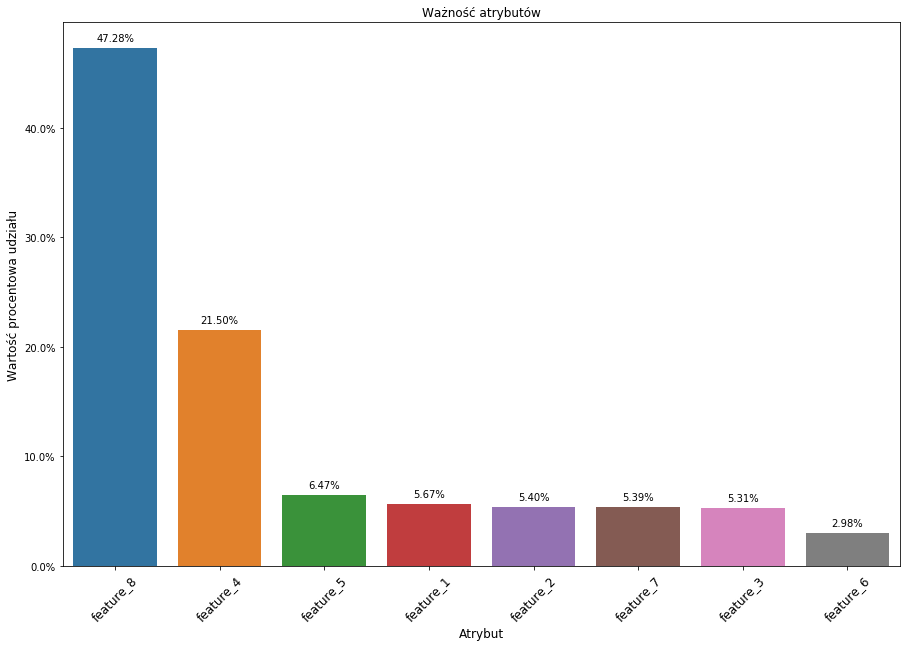

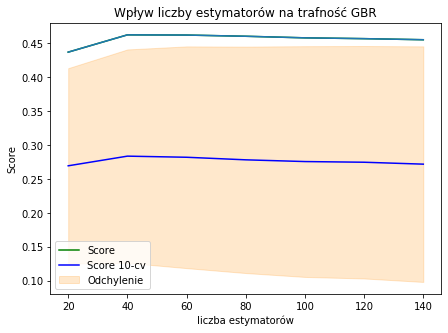

RFR20 R squared: 0.4500
RMSE: 6551.1983
RFR40 R squared: 0.4492
RMSE: 6555.7943
RFR60 R squared: 0.4515
RMSE: 6542.3379
RFR80 R squared: 0.4478
RMSE: 6564.0779
RFR100 R squared: 0.4478
RMSE: 6564.2404
RFR120 R squared: 0.4477
RMSE: 6564.8695
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5811,
 'verbose': 0,
 'warm_start': False}
RFR120 R squared: 0.4515
RMSE: 6542.3379
           importance
feature_8    0.438550
feature_4    0.189827
feature_5    0.083244
feature_2    0.068753
feature_1    0.061902
feature_3    0.061840
feature_7    0.059367
feature_6    0.036517


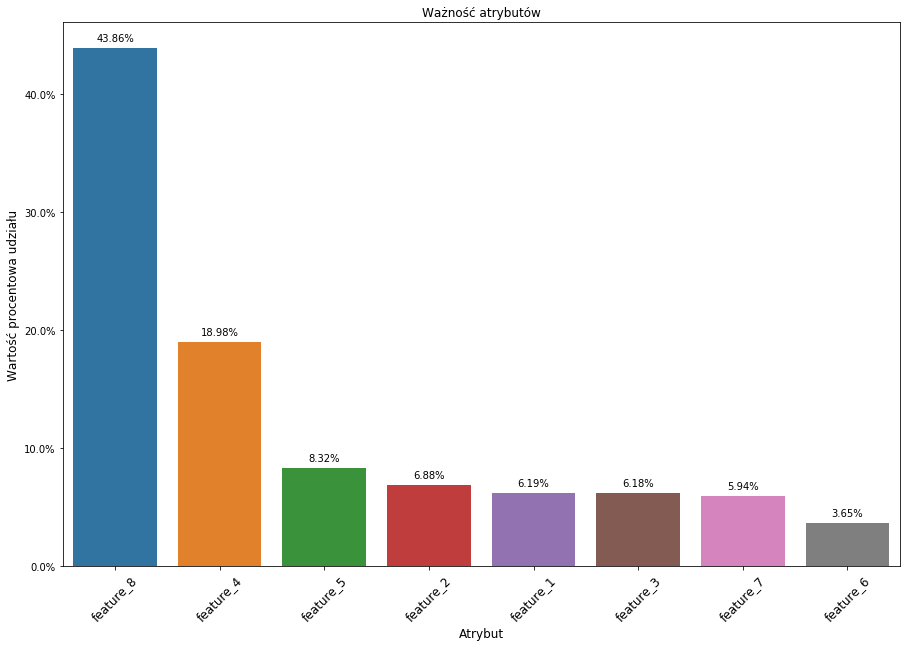

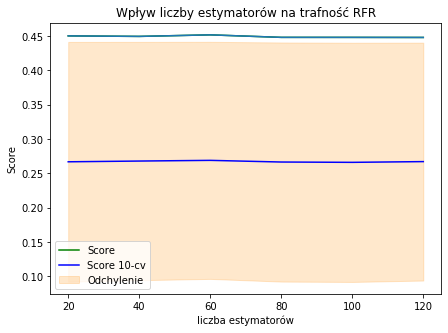

GBR20 R squared: 0.7677
RMSE: 4197.2668
GBR40 R squared: 0.8273
RMSE: 3619.5454
GBR60 R squared: 0.8408
RMSE: 3475.2953
GBR80 R squared: 0.8423
RMSE: 3458.2558
GBR100 R squared: 0.8426
RMSE: 3455.3427
GBR120 R squared: 0.8430
RMSE: 3450.8174
GBR140 R squared: 0.8428
RMSE: 3453.0872
Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 5811,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR140 R squared: 0.8430
RMSE: 3450.8174
              importance
engine_power    0.420053
mileage         0.194192
model_key       0.190962
age             0.181494
car_type        0.010696


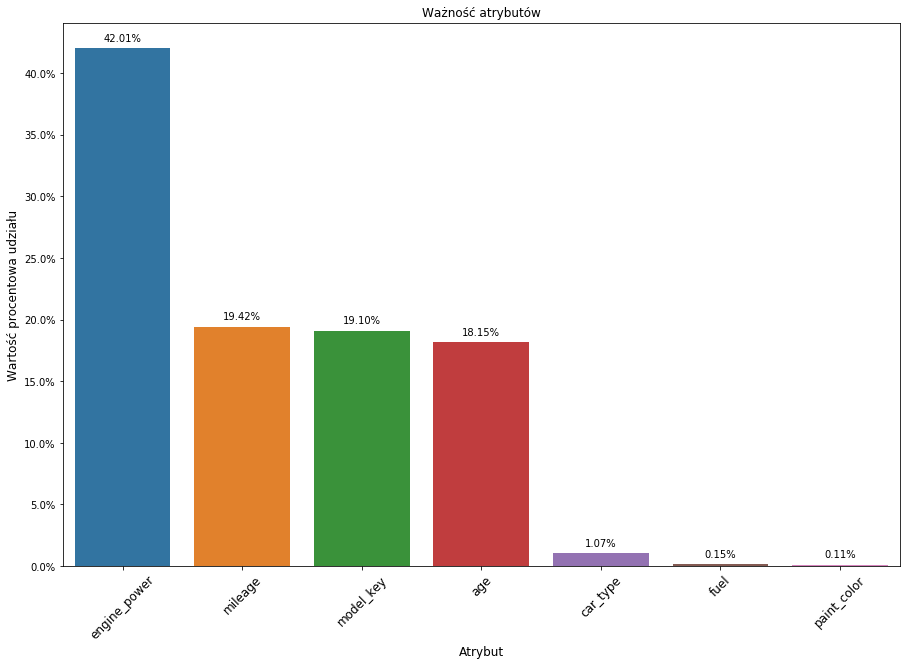

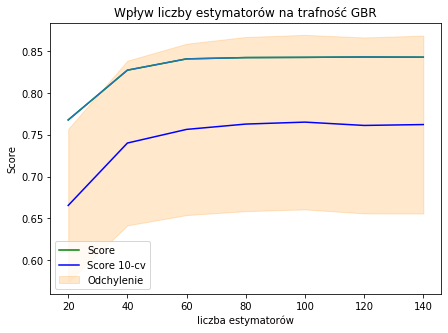

RFR20 R squared: 0.7628
RMSE: 4241.6006
RFR40 R squared: 0.7888
RMSE: 4002.0958
RFR60 R squared: 0.7962
RMSE: 3931.5203
RFR80 R squared: 0.8050
RMSE: 3845.7435
RFR100 R squared: 0.8055
RMSE: 3840.6925
RFR120 R squared: 0.8054
RMSE: 3842.2340
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5811,
 'verbose': 0,
 'warm_start': False}
RFR120 R squared: 0.8055
RMSE: 3840.6925
              importance
engine_power    0.410196
mileage         0.208958
age             0.181318
model_key       0.155810
paint_color     0.024201
car_type        0.017353
fuel            0.002165


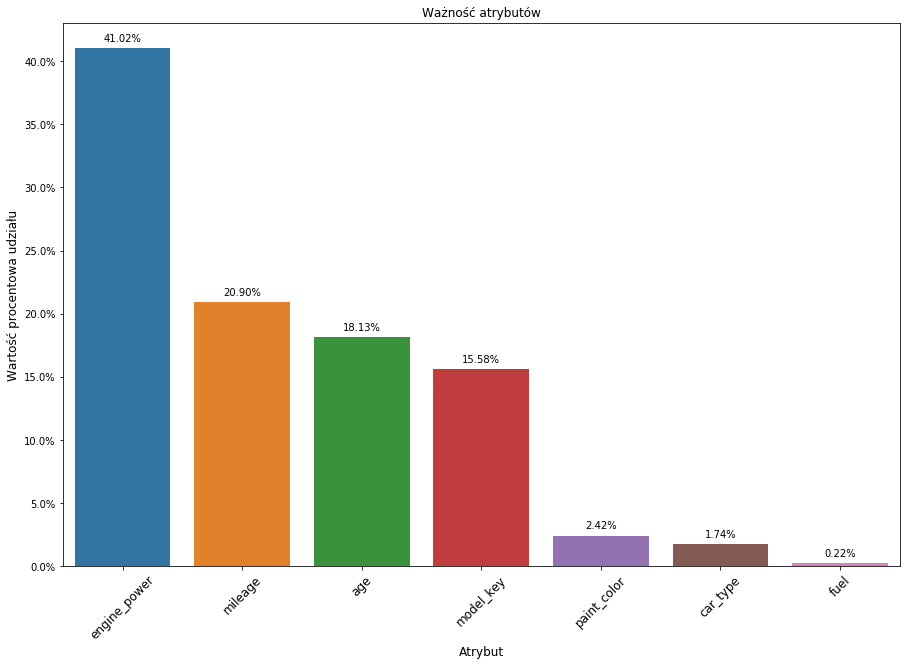

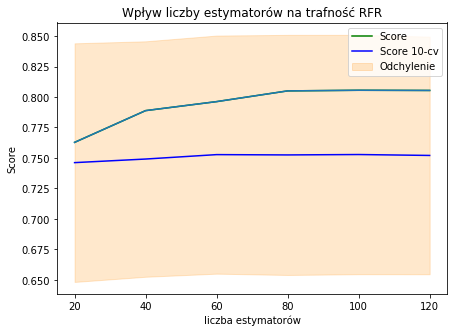

GBR20 R squared: 0.7978
RMSE: 4060.2479
GBR40 R squared: 0.8657
RMSE: 3308.7892
GBR60 R squared: 0.8830
RMSE: 3088.3674
GBR80 R squared: 0.8866
RMSE: 3040.4452
GBR100 R squared: 0.8889
RMSE: 3009.2950
GBR120 R squared: 0.8908
RMSE: 2983.5725
GBR140 R squared: 0.8920
RMSE: 2966.9220
Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 140,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 5811,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
GBR140 R squared: 0.8920
RMSE: 2966.9220
              importance
engine_power    0.368889
model_key       0.236213
mileage         0.194335
age             0.184355
car_type        0.012115


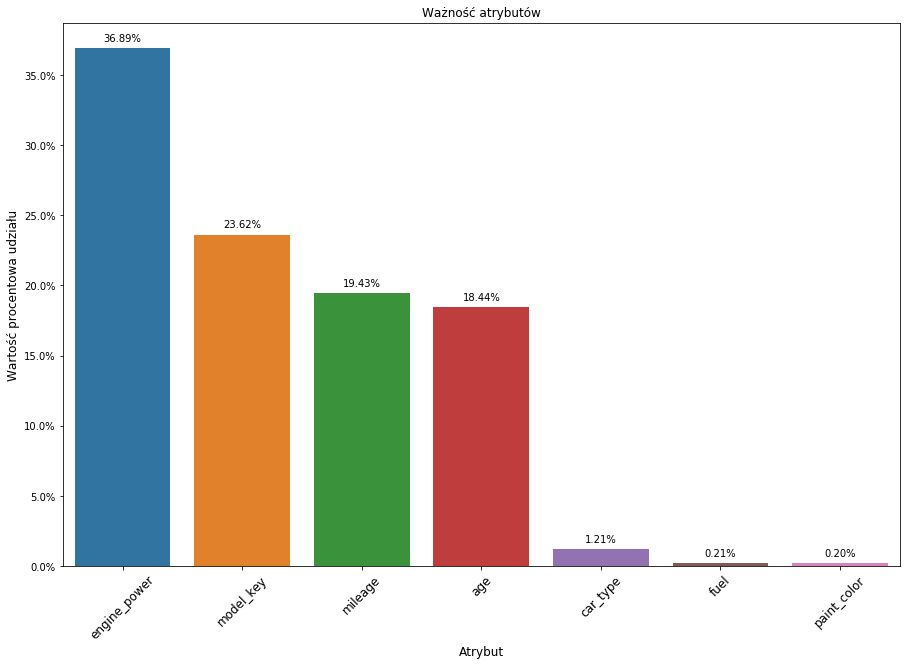

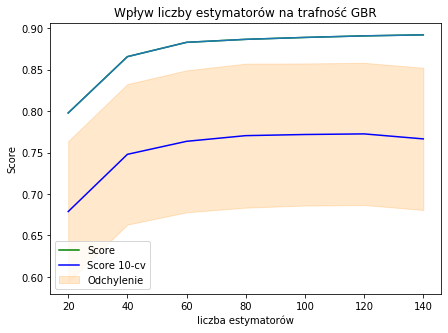

RFR20 R squared: 0.8860
RMSE: 3048.7495
RFR40 R squared: 0.8867
RMSE: 3038.9120
RFR60 R squared: 0.8863
RMSE: 3043.9951
RFR80 R squared: 0.8857
RMSE: 3052.4380
RFR100 R squared: 0.8861
RMSE: 3047.6481
RFR120 R squared: 0.8860
RMSE: 3048.5383
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5811,
 'verbose': 0,
 'warm_start': False}
RFR120 R squared: 0.8867
RMSE: 3038.9120
              importance
engine_power    0.368036
mileage         0.228739
model_key       0.193777
age             0.168632
paint_color     0.020162
car_type        0.018538
fuel            0.002117


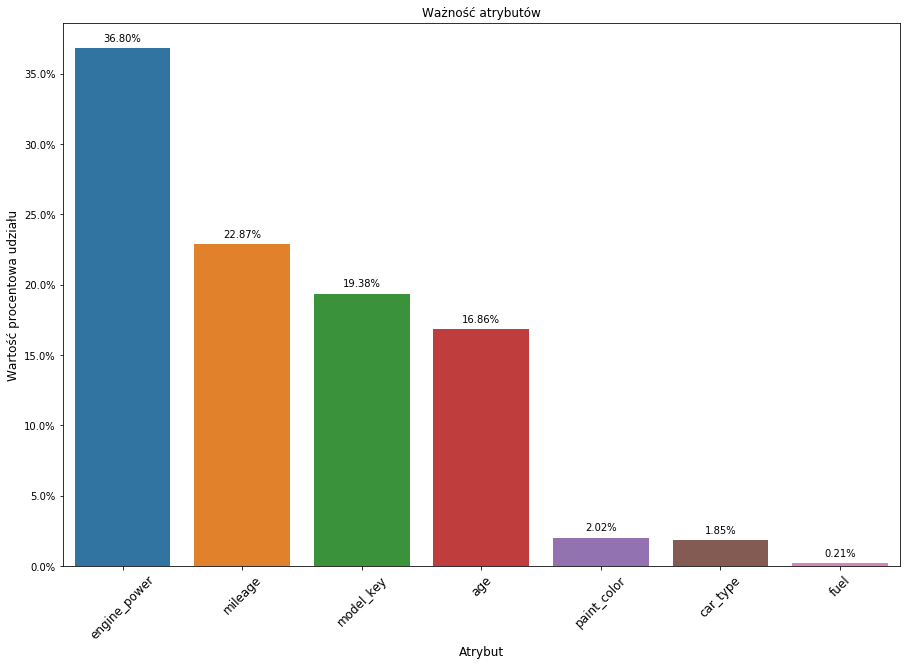

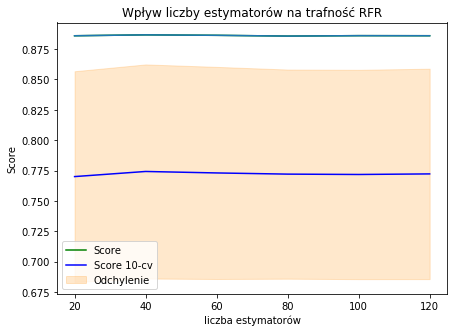

In [106]:
# Now lets use the 8 important features as described in the description file of the dataset
df_copy = df.copy()
df_copy_rep = replicate_low_count(df_copy.copy())
df_copy.drop(["engine_power",'mileage','paint_color',"age","model_key","car_type","fuel"],inplace=True,axis=1)
df_copy_rep.drop(["engine_power",'mileage','paint_color',"age","model_key","car_type","fuel"],inplace=True,axis=1)

df_copy2 = df.copy()
df_copy2.drop(list(("feature_" + str(i)) for i in range(1,9)), inplace=True,axis=1)
df_copy_rep2 = replicate_low_count(df_copy2.copy())

do_prediction(df_copy,False, "features")
do_prediction(df_copy_rep,True, "features_replic")

do_prediction(df_copy2,False, "no_features")
do_prediction(df_copy_rep2,True, "no_features_replic")